In [1]:
!pip install xee

In [9]:
import matplotlib.pyplot as plt
import ee
import geemap
import xarray as xr
import xee
import numpy as np
import pandas as pd
from datetime import datetime

In [3]:
ee.Authenticate()
ee.Initialize(project = 'air-quality-466614', opt_url = 'https://earthengine-highvolume.googleapis.com')

In [7]:
gaul = (ee.FeatureCollection("FAO/GAUL/2015/level2")
        .filter(ee.Filter.eq('ADM0_NAME', 'Sri Lanka')))

roi = gaul.geometry()

In [17]:
province_mapping = {
    '1': 'Western',
    '2': 'Central',
    '3': 'Southern',
    '4': 'Northern',
    '5': 'Eastern',
    '6': 'North Western',
    '7': 'North Central',
    '8': 'Uva',
    '9': 'Sabaragamuwa'
}

In [10]:
# Create province and district mapping
province_district_mapping = {
    '1': {'Western': ['1A Colombo', '1B Gampaha', '1C Kalutara']},
    '2': {'Central': ['2A Kandy', '2B Matale', '2C Nuwara Eliya']},
    '3': {'Southern': ['3A Galle', '3B Matara', '3C Hambantota']},
    '4': {'Northern': ['4A Jaffna', '4B Kilinochchi', '4C Mannar', '4D Vavuniya', '4E Mullaitivu']},
    '5': {'Eastern': ['5A Trincomalee', '5B Batticaloa', '5C Ampara']},
    '6': {'North Western': ['6A Kurunegala', '6B Puttalam']},
    '7': {'North Central': ['7A Anuradhapura', '7B Polonnaruwa']},
    '8': {'Uva': ['8A Badulla', '8B Monaragala']},
    '9': {'Sabaragamuwa': ['9A Ratnapura', '9B Kegalle']}
}


**Monthly Data**

In [11]:
monthly_data = (ee.ImageCollection("projects/sat-io/open-datasets/GHAP/GHAP_M1K_PM25").filterDate('2017','2023'))

In [12]:
monthly_dataset=xr.open_dataset(monthly_data,
                                engine='ee',
                                crs='EPSG:4326',
                                geometry=roi,
                                scale=0.001
                                )

In [ ]:
quarterly_mean_scaled = quarterly_mean * 0.1
quarterly_mean

<xarray.Dataset> Size: 739MB
Dimensions:  (year: 5, quarter: 4, lon: 2358, lat: 3916)
Coordinates:
  * year     (year) int64 40B 2018 2019 2020 2021 2022
  * quarter  (quarter) int64 32B 1 2 3 4
  * lon      (lon) float64 19kB 79.52 79.52 79.52 79.52 ... 81.88 81.88 81.88
  * lat      (lat) float64 31kB 5.92 5.921 5.922 5.923 ... 9.833 9.834 9.835
Data variables:
    b1       (lon, lat, year, quarter) float32 739MB nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

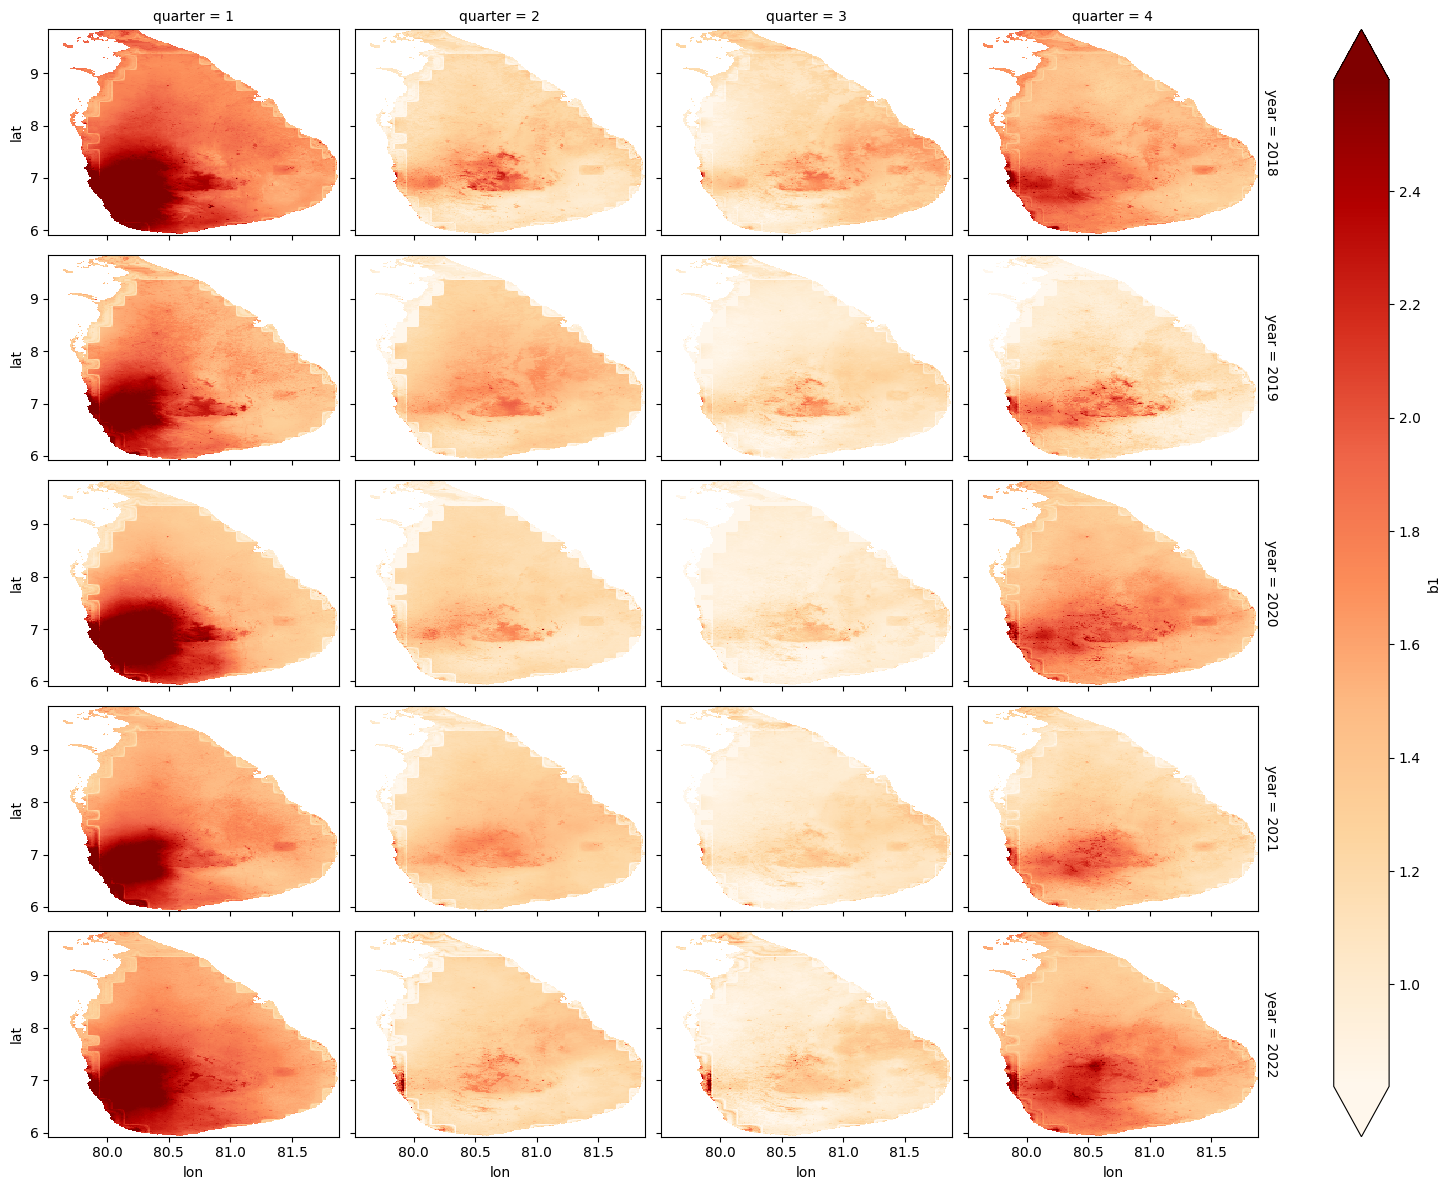

In [ ]:
quarterly_mean_scaled.b1.plot(
    x="lon",
    y="lat",
    row="year",        # each row = one year
    col="quarter",     # each column = one quarter
    robust=True,
    cmap="OrRd",
    figsize=(16, 12)
)

plt.savefig("Quarterly_PM25_by_Year.png", dpi=360, bbox_inches="tight")


**Province Mapping & Geometry Setup**

In [48]:
# --- Correct Province mapping using actual GAUL codes ---
province_mapping = {
    2736: 'Western',
    2737: 'Central',
    2738: 'Southern',
    2739: 'Northern',
    2740: 'Eastern',
    2741: 'North Western',
    2742: 'North Central',
    2743: 'Uva',
    2744: 'Sabaragamuwa'
}

# Alternative mapping in case GAUL codes are strings
alternative_mapping = {str(k): v for k, v in province_mapping.items()}

# --- Load provinces (GAUL Level 1 = provinces) ---
provinces = (ee.FeatureCollection("FAO/GAUL/2015/level1")
             .filter(ee.Filter.eq('ADM0_NAME', 'Sri Lanka')))

# --- Inspect GAUL properties ---
first_province = provinces.first().getInfo()
print("Available properties in GAUL:", list(first_province['properties'].keys()))
print("Sample province data:", first_province['properties'])


Available properties in GAUL: ['ADM0_CODE', 'ADM0_NAME', 'ADM1_CODE', 'ADM1_NAME', 'DISP_AREA', 'EXP1_YEAR', 'STATUS', 'STR1_YEAR', 'Shape_Area', 'Shape_Leng']
Sample province data: {'ADM0_CODE': 231, 'ADM0_NAME': 'Sri Lanka', 'ADM1_CODE': 2736, 'ADM1_NAME': 'Central', 'DISP_AREA': 'NO', 'EXP1_YEAR': 3000, 'STATUS': 'Member State', 'STR1_YEAR': 1000, 'Shape_Area': 0.468861794853, 'Shape_Leng': 4.73722153932}


Load & Process Monthly PM2.5 Data

In [63]:
monthly_data = (ee.ImageCollection("projects/sat-io/open-datasets/GHAP/GHAP_M1K_PM25")
                .filterDate('2017-01-01', '2023-12-31'))

# Correct quarter calculation: Jan-Mar → Q1, Apr-Jun → Q2, etc.
def add_quarter(img):
    date = ee.Date(img.get('system:time_start'))
    year = date.get('year')
    month = date.get('month')
    quarter = ee.Number(month).subtract(1).divide(3).floor().add(1)
    return img.set('year', year).set('quarter', quarter)

monthly_data = monthly_data.map(add_quarter)


In [64]:
def create_quarterly_composite(year, quarter):
    filtered = monthly_data.filter(ee.Filter.eq('year', year)) \
                           .filter(ee.Filter.eq('quarter', quarter))
    size = filtered.size()
    mean_img = filtered.mean()

    # Return None if no image exists
    return ee.Algorithms.If(
        size.gt(0),
        mean_img.set({'year': year, 'quarter': quarter}),
        None
    )

years = ee.List.sequence(2017, 2023)
quarters = ee.List.sequence(1, 4)

quarterly_composites = years.map(lambda y:
                                 quarters.map(lambda q: create_quarterly_composite(y, q))
                                ).flatten()

quarterly_ic = ee.ImageCollection(quarterly_composites).filter(ee.Filter.neq('year', None))


In [65]:
def compute_province_means(img):
    year = ee.Number(img.get('year'))
    quarter = ee.Number(img.get('quarter'))

    stats = img.reduceRegions(
        collection=provinces,
        reducer=ee.Reducer.mean(),
        scale=1000,
        crs='EPSG:4326'
    )

    return stats.map(lambda f: f.set({
        'year': year,
        'quarter': quarter,
        'province_name': f.get('ADM1_NAME')
    }))

province_stats_fc = ee.FeatureCollection(quarterly_ic.map(compute_province_means).flatten())


In [66]:
features = province_stats_fc.getInfo()['features']

rows = []
for f in features:
    props = f['properties']

    province_name = props.get('province_name') or props.get('ADM1_NAME')
    province_code = props.get('ADM1_CODE')

    if province_name:
        province_name = province_name.replace('Sri Lanka: ', '').replace(' Province', '')
    if not province_name and province_code:
        province_name = province_mapping.get(province_code)

    year = props.get('year')
    quarter = props.get('quarter')
    pm25 = props.get('mean')

    rows.append({
        "Province": province_name,
        "Province_Code": province_code,
        "Year": int(year),
        "Quarter": int(quarter),
        "PM25": float(pm25) if pm25 is not None else np.nan
    })

df = pd.DataFrame(rows)

# Ensure all quarters exist per province/year
all_combinations = pd.MultiIndex.from_product(
    [df['Province'].unique(), range(1,5), df['Year'].unique()],
    names=['Province','Quarter','Year']
)
df = df.set_index(['Province','Quarter','Year']).reindex(all_combinations).reset_index()

# Create datetime and YearQuarter columns
df['Date'] = pd.to_datetime(df['Year'].astype(str) + 'Q' + df['Quarter'].astype(str))
df['YearQuarter'] = df['Year'].astype(str) + 'Q' + df['Quarter'].astype(str)


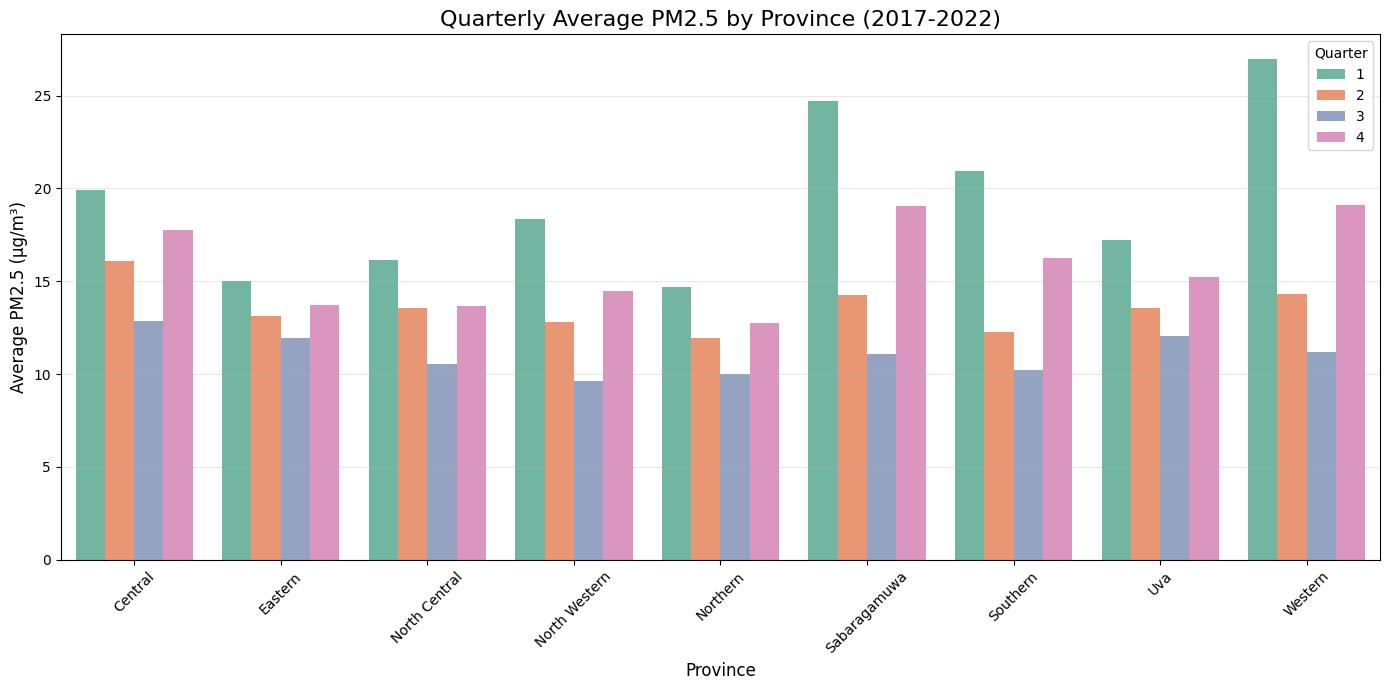

In [68]:
quarterly_avg = df.groupby(['Province','Quarter'])['PM25'].mean().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=quarterly_avg, x='Province', y='PM25', hue='Quarter', palette='Set2')

plt.title('Quarterly Average PM2.5 by Province (2017-2022)', fontsize=16)
plt.xlabel('Province', fontsize=12)
plt.ylabel('Average PM2.5 (μg/m³)', fontsize=12)
plt.legend(title='Quarter', loc='upper right')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()
